<a href="https://colab.research.google.com/github/rliu7926/nie-research-project/blob/master/3.5%20Distance%20Estimation%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns

     |████████████████████████████████| 3.1MB 2.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 150kB/s 
     |████████████████████████████████| 1.6MB 42.8MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
     |████████████████████████████████| 890kB 40.3MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 3.2MB 40.6MB/s 


In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1, mass2, resolution, frequencybound, distance, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Taken from notebook 3.2 (SNR expectation value without any noise)

def expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))
  

In [ ]:
## Taken from notebook 2.2 (SNR value with noise)

def determine_SNR(mass1, mass2, waveformmass1, waveformmass2, resolution, frequencybound, psdresolution, distance, noise, noisetime, graph = "F"):

  gwamp, gwtime = create_waveform(mass1, mass2, resolution, frequencybound, distance)

  # Generate the frequency series PSD

  samples = int(4096 / psdresolution) + 1

  designpsd = pycbc.psd.from_string(psd_name = noise,
                                         length = samples,
                                         delta_f = psdresolution, 
                                         low_freq_cutoff = frequencybound)

  # Generate [noisetime] seconds of Gaussian noise at [1/resolution] Hz

  timesamples = int(noisetime / resolution)
  gaussiannoise = pycbc.noise.gaussian.noise_from_psd(length = timesamples, 
                                                      delta_t = resolution,
                                                      psd = designpsd,
                                                      seed = None)
  
  # Resize GW signal to the length of the random noise sample

  timeshift = randint(0, len(gaussiannoise)-len(gwamp)) # Add a random timeshift
  gwamp = np.append([0] * timeshift, gwamp) # Append zeroes before the wave
  gwamp = np.append(gwamp, [0] * (len(gaussiannoise)-len(gwamp))) # Append zeroes after the wave 
  gwtime = gaussiannoise.sample_times

  ## Add the waveform to the generated noise

  gwnoise = gaussiannoise + gwamp

  ## Calculate the SNR time series 

  waveform_template, waveform_template_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                                               mass1=waveformmass1,
                                                               mass2=waveformmass2,
                                                               delta_t=resolution, 
                                                               f_lower=frequencybound)

  waveform_template.resize(len(gaussiannoise))
  waveform_template = waveform_template.cyclic_time_shift(waveform_template.start_time)

  ## Calculate and plot the SNR
  
  psd = gwnoise.psd(4)
  psd = interpolate(psd, gwnoise.delta_f)
  psd = inverse_spectrum_truncation(psd, 4*gwnoise.sample_rate, low_frequency_cutoff=frequencybound)

  gwsnr = matched_filter(template=waveform_template,
                         data=gwnoise,
                         psd = psd,
                         low_frequency_cutoff=frequencybound)
  
  if graph == "T":
    pylab.figure()
    pylab.plot(gwsnr.sample_times, abs(gwsnr))

  gwsnrpeak = abs(gwsnr).numpy().argmax()
  gwsnrpeakvalue = gwsnr[gwsnrpeak]
  gwsnrpeaktime = gwsnr.sample_times[gwsnrpeak]

  print("A signal was found at {} s with SNR {}.".format(gwsnrpeaktime, abs(gwsnrpeakvalue)))
  print("The redshifted waveform was inserted at time {} s.".format(timeshift*resolution))

  return(abs(gwsnrpeakvalue))


In [ ]:
## Create basic function for parameter estimation 

def estimate_parameter1(function, guess, desired, alpha, iterations): 

  ## Initial guess
  pred = guess
  estimate = function(pred)
  print("Initial guess: {}".format(estimate))

  ## Update guess and iterate
  for i in range(iterations): 
    diff = desired - estimate
    pred = pred + alpha * diff
    estimate = function(pred)
    print("Iteration {}: {}".format(i, estimate))

  diff = desired - estimate
  print("Final estimate: {}, off by {}".format(pred, diff))
  return(estimate)  


In [ ]:
## Test the general parameter estimation function
def test(x):
  return(x**2)

estimate_parameter1(function=test, guess=2, desired=100, alpha=0.03, iterations=20)

In [ ]:
## Create function for parameter estimation with multiple parameters

def estimate_parameter2(function, guess, desired, alpha, iterations, x, y): 

  ## Initial guess
  
  if x == 'param':
    pred = guess
    constant = y
    estimate = function(pred, y)
    print("Initial guess: {}".format(estimate))

    for i in range(iterations): 
      diff = desired - estimate
      pred = pred + alpha * diff
      estimate = function(pred, y)
      print("Iteration {}: {}".format(i, estimate))

  if y == 'param':
    pred = guess
    constant = x
    estimate = function(x, pred)
    print("Initial guess: {}".format(estimate))
    
    for i in range(iterations): 
      diff = desired - estimate
      pred = pred + alpha * diff
      estimate = function(x, pred)
      print("Iteration {}: {}".format(i, estimate))

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(estimate)  


In [ ]:
def test(x,y):
  return(x**2 * y**1.1)

estimate_parameter2(function=test, guess=2, desired=1000, alpha=0.01, iterations=20, x='param', y=2)
estimate_parameter2(function=test, guess=2, desired=1000, alpha=0.05, iterations=20, x=2, y='param')



In [ ]:
## Create distance estimation function

def estimate_distance(snr, guess, alpha, iterations, mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance='param', psd='aLIGODesignSensitivityP1200087', cosmology=Planck18): 
  
  if distance == 'param':
    pred = guess
    estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
    print("Initial guess: {}".format(estimate))

    for i in range(iterations):
      diff = snr - estimate
      pred = pred + alpha * diff
      estimate = expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, pred, psd, cosmology)
      print("Iteration {}: {}".format(i, estimate))
    
  else: 
    print("Nothing to estimate: distance needs to be set to param")

  print("Final estimate: {}, off by {}".format(pred, diff))
  return(pred) 

In [ ]:
## Test distance estimation function 

estimate_distance(snr=8, guess=1000, alpha=-25, iterations=50,
                  mass1=30, mass2=30, templatemass1=30, templatemass2=30, resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance='param')

In [ ]:
## Distance estimation with varying black hole masses

masslist = np.arange(25, 75, 5)
distlist = [0] * len(masslist)

for i in range(len(masslist)):
  alpha = -25 - i
  distlist[i] = estimate_distance(snr=8, guess=1000, alpha=alpha, iterations=50,
                                  mass1=masslist[i], mass2=masslist[i], templatemass1=masslist[i], templatemass2=masslist[i],
                                  resolution=1.0/1024, psdresolution=1.0/16, lowfreq=20, distance='param')

Text(0, 0.5, 'Distance (Mpc)')

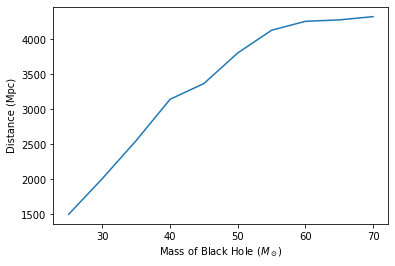

In [ ]:
pylab.plot(masslist, distlist)
pylab.xlabel("Mass of Black Hole ($M_\odot$)")
pylab.ylabel("Distance (Mpc)")
